In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from scipy.optimize import bisect
from scipy.stats import binom

from utils import save_checkpoint_withEval as save_checkpoint
from utils import restore_checkpoint_withEval as restore_checkpoint
from loadDataPipeline import generateData

import sys

sys.path.append("score_sde_pytorch/")
#%load_ext blackcellmagic

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-09-12 21:01:32.833048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from torch.utils.cpp_extension import load

# from score_sde_pytorch.models import ncsnpp
from configs.vp import cifar10_ncsnpp_continuous as configLoader
from models import utils as mutils
from models.ema import ExponentialMovingAverage

### Loading the ML model from Song et al.

In [3]:
config = configLoader.get_config()
config.training.batch_size = 128
config.training.snapshot_freq_for_preemption = 10
config.training.snapshot_freq = 50_000
config.training.log_freq = 100

config.data.dataset = "CELEBA"
config.data.image_size = 64
config.data.data_path = "/project/smartFRACs/jesantos/generative-discrete-state-diffusion-models/dataBuffer/celebA/celebA_64_64.npy"

### Our parameters

In [4]:
config.model.num_scales = 1_000
config.model.num_bins = 256
config.model.t_end = 15

### Solving for observation times (noise schedule) and forward solution or directly loading previously saved ones

In [5]:
def f(x):
    return np.log(x / (1 - x))

In [23]:
class blackout_loader(Dataset):
    def __init__(self, config):

        self.T = config.model.num_scales
        self.t_end = config.model.t_end
        self.im_size = config.data.image_size
        self.batch_size = config.training.batch_size
        self.num_bins = 256

        self.forward_solution()
        self.compute_weights()
        self.load_data()

    def forward_solution(self):

        x_end = np.exp(-self.t_end)
        f_grid = np.linspace(-f(x_end), f(x_end), self.T)
        x_grid = np.array(
            [
                bisect(lambda x: f(x) - f_grid[i], x_end / 2, 1 - x_end / 2)
                for i in range(self.T)
            ]
        )
        self.observation_times = -np.log(x_grid)

        table = np.zeros((self.num_bins, self.num_bins))
        for n in range(self.num_bins):
            for m in range(n):
                table[n, m] = n - m
            table[n, n] = 0
        self.table = np.repeat(table[:, :, None], self.T, axis=2).flatten()

        support = np.arange(self.num_bins)
        sol = np.zeros((self.T + 1, self.num_bins, self.num_bins))
        sol[0, :, :] = np.eye(self.num_bins)

        self.pt = np.exp(-self.observation_times)
        for t in range(self.T):
            for i in range(self.num_bins):
                sol[t + 1, :, i] = binom(i, self.pt[t]).pmf(support)
        self.cumulative = np.cumsum(sol, axis=1)

    def compute_weights(self):

        self.sampling_prob = np.ones_like(self.pt) / np.sum(np.ones_like(self.pt))
        self.weights = (self.pt * np.diff(self.observation_times, prepend=0) / self.sampling_prob)
        
    def load_data(self):

        self.data = np.load(config.data.data_path).transpose((0, 3, 1, 2))
        self.training_ims = self.data.shape[0]
        self.num_batches = int(self.training_ims / self.batch_size)
        return

    def __len__(self):
        return self.num_batches

    def return_items(self, ims, ts):
        
        cp = self.cumulative[ts + 1, :, ims]
        u = np.random.uniform(size=(cp.shape[0], 3, self.im_size, self.im_size, 1))
        nt = np.argmax(u < cp, axis=4)

        index = self.T * (self.num_bins * ims + nt) + ts

        birth_rate = self.table[index]
        mean_v = 127.5 * self.pt[ts]

        target = nt - mean_v
        
        return target, birth_rate, self.weights[ts]
        
    def __getitem__(self, idx):

        ims_ind = torch.randperm(self.training_ims)[: self.batch_size]
        ims = self.data[ims_ind]
        t_inds = np.random.choice(self.T, size=(self.batch_size, 1, 1, 1), p=self.sampling_prob)

        return t_inds, *self.return_items(ims, t_inds)

In [24]:
train_loader = DataLoader(
    blackout_loader(config),
    batch_size=None,
    pin_memory=True,
    num_workers=16,
    shuffle=True,
)

### Visualize one batch

In [14]:
def swap_ch(tensor):
    if isinstance(tensor, (np.ndarray, torch.Tensor)):
        if len(tensor.shape) == 3:
            return tensor.transpose(1, 2, 0) if isinstance(tensor, np.ndarray) else tensor.permute(1, 2, 0)
        elif len(tensor.shape) == 4:
            return tensor.transpose(0, 2, 3, 1) if isinstance(tensor, np.ndarray) else tensor.permute(0, 2, 3, 1)
    return None

In [28]:
num_ims = 10 
t_s = np.linspace(50, config.model.num_scales-1, num_ims, dtype=int)
ims = train_loader.dataset.data[:num_ims]

target, birth_rate, _ = train_loader.dataset.return_items(ims, t_s[:,None,None,None])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


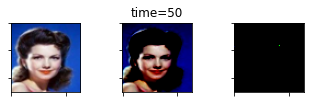

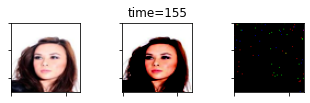

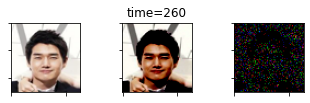

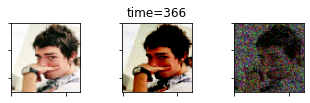

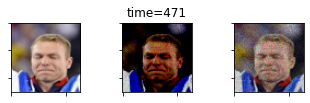

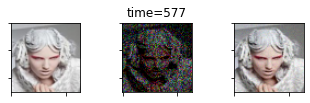

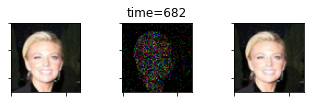

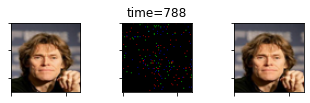

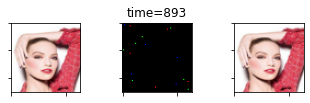

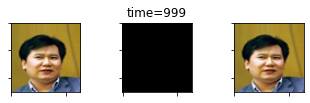

In [29]:
for i in range(num_ims):
    
    im = swap_ch( ims[i,] )
    out_im = swap_ch( 127.5*(target[i,]+1).astype('int32') )
    br = swap_ch( birth_rate[i,] )
    time = t_s[i,]
    
    
    fig, ax = plt.subplots(1,3, figsize=(4.8,1.5))
    
    ax[0].imshow(im)
    
    ax[1].imshow(out_im/np.max(out_im) if np.max(out_im) != 0 else out_im)
        
    ax[1].set_title(f'{time=}')
    
    ax[2].imshow((br - np.min(br)) / max(np.max(br) - np.min(br), 1))

    [ax[j].set_xticklabels('') and ax[j].set_yticklabels('') for j in range(3)]
    
    fig.tight_layout() 

### Instantiate an ML model to learn the transition rate

In [11]:
workdir = "blackout-celebA64"

score_model = mutils.create_model(config)
score_fn = mutils.get_model_fn(score_model, train=True)
optimizer = torch.optim.Adam(score_model.parameters(), lr=config.optim.lr)

ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)

state = dict(
    optimizer=optimizer,
    model=score_model,
    ema=ema,
    lossHistory=[],
    evalLossHistory=[],
    step=0,
)

checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")

tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)

initial_step = int(state["step"])
loss_history = state["loss_history"]
eval_history = state["eval_history"]

KeyError: 'ncsnpp'

### Training

In [26]:
softplus = torch.nn.functional.softplus
iterloader = iter(train_loader)

for step in range(initial_step, config.training.n_iters):

    t, ims, birth_rate, w = next(iterloader)
    optimizer.zero_grad()
    y = softplus(score_fn(ims, t))
    loss = torch.mean(w * (y - birth_rate * torch.log(y)))
    loss.backward()

    state["ema"].update(state["model"].parameters())

    optimizer.step()
    loss_history.append(loss.detach())

    if step != 0 and step % config.training.snapshot_freq_for_preemption == 0:
        save_checkpoint(checkpoint_meta_dir, state)

    if (
        step != 0
        and step % config.training.snapshot_freq == 0
        or step == config.training.n_iters
    ):
        save_step = step // config.training.snapshot_freq
        save_checkpoint(os.path.join(checkpoint_dir, f"checkpoint_{save_step}.pth"), state)

    if np.mod(step, config.training.log_freq) == 0:

        ema.store(score_model.parameters())
        ema.copy_to(score_model.parameters())

        y = softplus(score_fn(ims, t))
        loss = torch.mean(w * (y - birth_rate * torch.log(y)))

        ema.restore(score_model.parameters())
        eval_history.append(loss.detach())

        print(f"iter: {step}, loss: {loss_history[-1]}, eval loss: {eval_history[-1]}")

    state["step"] = step
    state["loss_history"] = loss_history
    state["eval_history"] = eval_history

NameError: name 'initial_step' is not defined